<a href="https://colab.research.google.com/github/SC1DR-OFFICIAL/img2latex/blob/main/img2latex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Поставка задачи

Разработать нейросеть seq2seq с механизмом внимания, которая преобразует изображения в формат LaTeX (математические формулы).

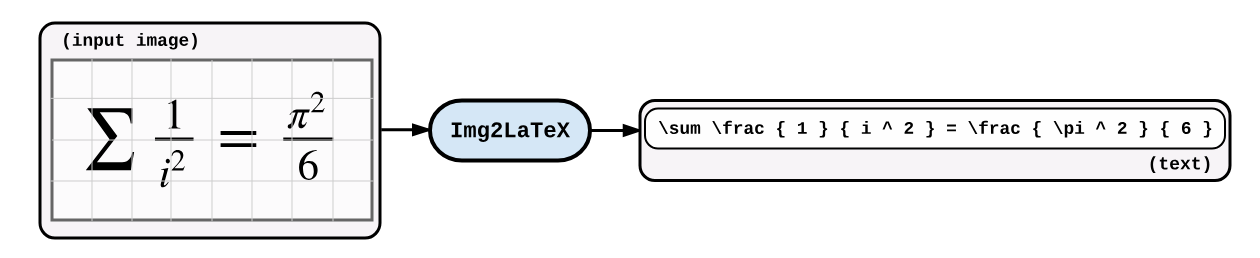

## Загрузка необходимых модулей

In [90]:
import os
from PIL import Image, ImageOps
import numpy as np
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import shutil
import logging
import subprocess
import re
import argparse
import sys
from pathlib import Path
import csv, cv2, matplotlib.pyplot as plt, textwrap
import tensorflow as tf
from tensorflow.keras import layers as L, Model
import time
import pathlib
import math
import zipfile

Для загрузки датасета с zendo

In [91]:
!pip install -q zenodo-get

Google Drive для сохранения

In [92]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Для токенизации

In [93]:
!pip install -q pylatexenc

Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/main.py", line 78, in main
    command = create_command(cmd_name, isolated=("--isolated" in cmd_args))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/__init__.py", line 114, in create_command
    module = importlib.import_module(module_path)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1204, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1176, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1147, in _find_and_load_unlo

## Подготовка данных

Функции для работы с путями

In [94]:
def count_files_in_directory(directory_path):
    """Возвращает общее количество файлов по заданному пути, включая подкаталоги."""
    count = 0
    for root, dirs, files in os.walk(directory_path):
        count += len(files)
    return count

In [95]:
def count_png_files_in_directory(directory_path):
    """Считает количество .png-файлов в заданной директории, игнорируя подкаталоги."""
    return sum(1 for f in os.listdir(directory_path)
               if os.path.isfile(os.path.join(directory_path, f)) and f.lower().endswith('.png'))

In [96]:
def remove_directory(path):
    """Удаляет папку по заданному пути, если она существует."""
    if os.path.exists(path) and os.path.isdir(path):
        shutil.rmtree(path)
        print(f"Папка '{path}' успешно удалена.")
    else:
        print(f"Папка '{path}' не существует или это не директория.")

### Загрузка датасета

Используем датасет im2latex-100k

In [97]:
# Папка в локальной сессии Colab для загрузки датасета
raw_dataset_dir = "/content/raw_dataset"

# Создаём папку (если ещё не существует)
!mkdir -p "{raw_dataset_dir}"

# Загружаем датасет с Zenodo в указанную папку
!zenodo_get 56198 -o "{raw_dataset_dir}"

Title: im2latex-100k ,  arXiv:1609.04938
Keywords: im2latex, latex, tex, formula, openai
Publication date: 2016-06-21
DOI: 10.5281/zenodo.56198
Total size: 306.8 MB

File: im2latex_validate.lst (213.7 kB)
Link: https://zenodo.org/api/records/56198/files/im2latex_validate.lst/content
im2latex_validate.lst is already downloaded correctly.

File: readme.txt (924 Bytes)
Link: https://zenodo.org/api/records/56198/files/readme.txt/content
readme.txt is already downloaded correctly.

File: im2latex_test.lst (237.4 kB)
Link: https://zenodo.org/api/records/56198/files/im2latex_test.lst/content
im2latex_test.lst is already downloaded correctly.

File: im2latex_train.lst (1.9 MB)
Link: https://zenodo.org/api/records/56198/files/im2latex_train.lst/content
im2latex_train.lst is already downloaded correctly.

File: im2latex_formulas.lst (12.3 MB)
Link: https://zenodo.org/api/records/56198/files/im2latex_formulas.lst/content
im2latex_formulas.lst is already downloaded correctly.

File: formula_images

Разархивируем изображения

In [98]:
!tar -xzf /content/raw_dataset/formula_images.tar.gz -C /content/raw_dataset

^C


Проверим количество

In [99]:
count_files_in_directory('/content/raw_dataset/formula_images')

103536

In [100]:
count_png_files_in_directory("/content/raw_dataset/formula_images")

103535

1 объект не является изображением! Проверим

In [101]:
folder_path = "/content/raw_dataset/formula_images"

# Проходимся по всем элементам в папке
for fname in os.listdir(folder_path):
    if not fname.lower().endswith('.png'):
        print(f"Найден файл не .png: {fname}")

Найден файл не .png: texput.log


Посмотрим случайные 5 картинок формул

In [102]:
def show_random_images(img_dir, n=5):
    """
    Показывает n случайных изображений из указанной папки img_dir.
    """
    all_imgs = [f for f in os.listdir(img_dir) if f.endswith('.png')]

    if len(all_imgs) < n:
        print(f"В папке всего {len(all_imgs)} изображений. Показываю все.")
        sample_imgs = all_imgs
    else:
        sample_imgs = random.sample(all_imgs, n)

    plt.figure(figsize=(3*n, 4))
    for i, fname in enumerate(sample_imgs):
        img_path = os.path.join(img_dir, fname)
        img = Image.open(img_path)
        plt.subplot(1, n, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(fname, fontsize=8)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

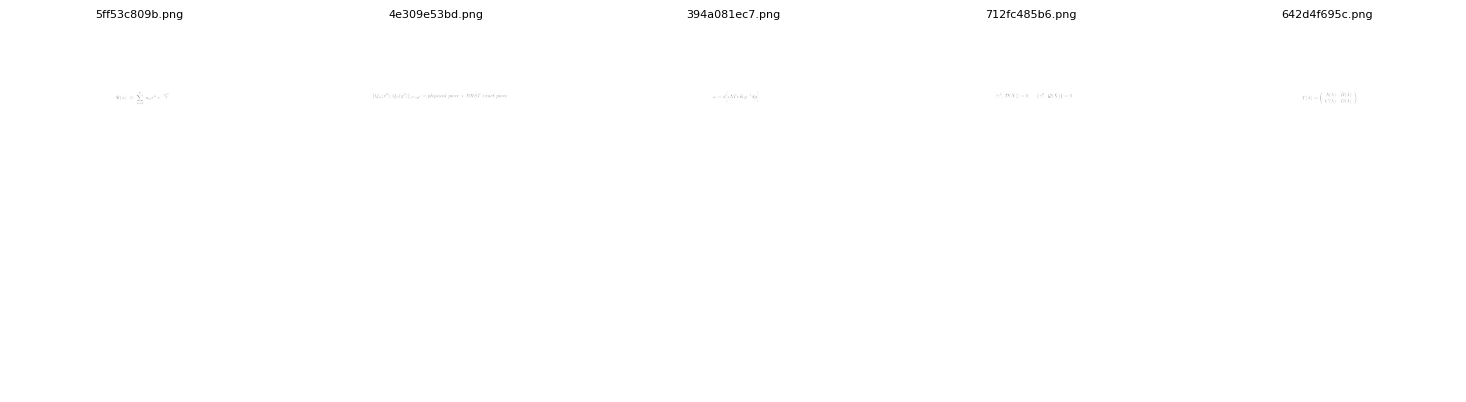

In [103]:
show_random_images('/content/raw_dataset/formula_images')

Изображения в наборе данных содержат формулу LaTeX, отрисованную на всю страницу. Для ускорения обучения необходимо выполнить предварительную обработку изображений.

**Нужно обрезать область формулы и сгруппировать изображения схожих размеров для облегчения пакетной обработки.**

## Предварительная обработка изображений для удобства обучения

### Функции для обработки изображений

In [104]:
# Обрезает изображение по границам формулы (удаляет белые поля)
def crop_image(img, output_path, default_size=None):
    old_im = Image.open(img).convert('L')
    img_data = np.asarray(old_im, dtype=np.uint8)
    nnz_inds = np.where(img_data != 255)
    if len(nnz_inds[0]) == 0:
        if not default_size:
            old_im.save(output_path)
            return False
        else:
            x_min, y_min, x_max, y_max = 0, 0, default_size[0], default_size[1]
            old_im = old_im.crop((x_min, y_min, x_max+1, y_max+1))
            old_im.save(output_path)
            return False
    y_min = np.min(nnz_inds[0])
    y_max = np.max(nnz_inds[0])
    x_min = np.min(nnz_inds[1])
    x_max = np.max(nnz_inds[1])
    old_im = old_im.crop((x_min, y_min, x_max+1, y_max+1))
    old_im.save(output_path)
    return True

# Добавляет паддинг вокруг изображения и масштабирует его до ближайшего подходящего bucket'а — заранее заданного размера из списка buckets
def pad_group_image(img, output_path, pad_size, buckets):
    PAD_TOP, PAD_LEFT, PAD_BOTTOM, PAD_RIGHT = pad_size
    old_im = Image.open(img)
    old_size = (old_im.size[0]+PAD_LEFT+PAD_RIGHT, old_im.size[1]+PAD_TOP+PAD_BOTTOM)
    j = -1
    for i in range(len(buckets)):
        if old_size[0] <= buckets[i][0] and old_size[1] <= buckets[i][1]:
            j = i
            break
    if j < 0:
        new_size = old_size
        new_im = Image.new("RGB", new_size, (255,255,255))
        new_im.paste(old_im, (PAD_LEFT, PAD_TOP))
        new_im.save(output_path)
        return False
    new_size = buckets[j]
    new_im = Image.new("RGB", new_size, (255,255,255))
    new_im.paste(old_im, (PAD_LEFT, PAD_TOP))
    new_im.save(output_path)
    return True

# Уменьшает изображение в ratio раз (по умолчанию 2.0) с сохранением качества (LANCZOS-фильтр)
def downsample_image(img, output_path, ratio):
    if ratio == 1:
        return True
    old_im = Image.open(img)
    old_size = old_im.size
    new_size = (int(old_size[0] / ratio), int(old_size[1] / ratio))
    new_im = old_im.resize(new_size, Image.LANCZOS)
    new_im.save(output_path)
    return True

## Запуск обработки всех изображений

In [ ]:
input_dir = f"/content/raw_dataset/formula_images"
output_dir = f"/content/preprocessed_dataset/formula_images"

os.makedirs(output_dir, exist_ok=True)

pad_size = [8, 8, 8, 8]
buckets = [[240,100], [320,80], [400,80], [400,100], [480,80], [480,100],
           [560,80], [560,100], [640,80], [640,100], [720,80], [720,100],
           [720,120], [720,200], [800,100], [800,320], [1000,200]]
default_size = [600, 60]
downsample_ratio = 2.0

files = [f for f in os.listdir(input_dir) if f.endswith('.png')]

for fname in tqdm(files):
    in_path = os.path.join(input_dir, fname)
    out_path = os.path.join(output_dir, fname)

    crop_image(in_path, out_path, default_size=default_size)
    pad_group_image(out_path, out_path, pad_size=pad_size, buckets=buckets)
    downsample_image(out_path, out_path, ratio=downsample_ratio)

Каждое изображение:
1. Обрезается по содержимому.
2. Приводится к стандартизированному размеру.
3. Уменьшается для ускорения обучения.
И сохраняется в папку:


```
/content/preprocessed_dataset/formula_images
```



Проверим

In [ ]:
count_png_files_in_directory('/content/preprocessed_dataset/formula_images')

In [ ]:
show_random_images('/content/preprocessed_dataset/formula_images')

Сохраним на диск

In [ ]:
!zip -r /content/formula_images.zip /content/preprocessed_dataset/formula_images

In [ ]:
!mv /content/formula_images.zip /content/drive/MyDrive/img2latex/

распаковать из Drive

In [ ]:
!unzip /content/drive/MyDrive/img2latex/formula_images.zip -d /content/preprocessed_dataset/

In [ ]:
!wc -l /content/raw_dataset/im2latex_formulas.lst

In [ ]:
!head -n 5 /content/raw_dataset/im2latex_formulas.lst

In [ ]:
files = [
    "/content/raw_dataset/im2latex_validate.lst",
    "/content/raw_dataset/im2latex_train.lst",
    "/content/raw_dataset/im2latex_test.lst"
]

total = 0
for path in files:
    with open(path, "rb") as f:  # читаем в бинарном режиме, чтобы не было проблем с кодировкой
        count = sum(1 for _ in f)
    print(f"{path}: {count}")
    total += count

print(f"\nОбщее количество строк: {total}")

In [ ]:
import os

folder = "/content/preprocessed_dataset/formula_images"

count = len([f for f in os.listdir(folder) if f.endswith(".png")])
print(f"Общее количество изображений: {count}")

## Пронумеруем каждую формулу из набора данных

In [ ]:
input_path = "/content/raw_dataset/im2latex_formulas.lst"
output_path = "/content/raw_dataset/im2latex_formulas_numbered.lst"

with open(input_path, "rb") as fin, open(output_path, "w", encoding="utf-8") as fout:
    for idx, raw_line in enumerate(fin):
        line = raw_line.decode("utf-8", errors="replace").rstrip("\n\r")
        fout.write(f"{idx}\t{line}\n")

print(f"Файл сохранён в {output_path}")

In [ ]:
!wc -l /content/raw_dataset/im2latex_formulas_numbered.lst

In [ ]:
!head -n 5 /content/raw_dataset/im2latex_formulas_numbered.lst

In [ ]:
!cat /content/raw_dataset/im2latex_train.lst \
     /content/raw_dataset/im2latex_validate.lst \
     /content/raw_dataset/im2latex_test.lst \
     > /content/raw_dataset/im2latex_all.lst

In [ ]:
!wc -l /content/raw_dataset/im2latex_all.lst

In [ ]:
!head -n 5 /content/raw_dataset/im2latex_all.lst

In [ ]:
!cut -d' ' -f1,2 /content/raw_dataset/im2latex_all.lst > /content/raw_dataset/im2latex_all_clean.lst

In [ ]:
!head -n 5 /content/raw_dataset/im2latex_all_clean.lst

# Объединяем в один датасет

In [ ]:
formulas_path = "/content/raw_dataset/im2latex_formulas_numbered.lst"
all_clean_path = "/content/raw_dataset/im2latex_all_clean.lst"
output_path = "/content/raw_dataset/im2latex_merged.lst"

# Загружаем formulas в словарь {id: формула}
formulas = {}
with open(formulas_path, "r", encoding="utf-8") as f:
    for line in f:
        parts = line.rstrip("\n").split("\t", 1)
        if len(parts) == 2:
            formulas[parts[0]] = parts[1]

# Объединяем с all_clean
with open(all_clean_path, "r", encoding="utf-8") as f_in, open(output_path, "w", encoding="utf-8") as f_out:
    for line in f_in:
        parts = line.strip().split()
        if len(parts) == 2:
            idx, img_id = parts
            formula = formulas.get(idx, "")
            f_out.write(f"{idx}\t{img_id}\t{formula}\n")

print(f"Файл сохранён: {output_path}")

In [ ]:
!wc -l /content/raw_dataset/im2latex_merged.lst

In [ ]:
!head -n 5 /content/raw_dataset/im2latex_merged.lst

In [ ]:
import matplotlib.pyplot as plt
import os

images_dir = "/content/preprocessed_dataset/formula_images"

def show_formula_and_image(number: int, path):
    # Ищем строку с заданным номером
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.rstrip("\n").split("\t")
            if parts[0] == str(number):
                img_id = parts[1]
                formula = parts[2]
                break
        else:
            print("Номер не найден")
            return

    print("Формула:")
    print(formula)

    # Строим путь к изображению
    img_path = os.path.join(images_dir, f"{img_id}.png")

    if os.path.exists(img_path):
        img = plt.imread(img_path)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.show()
    else:
        print("Изображение не найдено:", img_path)

In [ ]:
show_formula_and_image(103558, path = "/content/raw_dataset/im2latex_merged.lst")

## Токенезация и нормализация

**Нормализация**: Приводит все варианты записи к каноническому виду (однотипные пробелы, одинаковые макросы, отсутствие «мусора» вроде \r).

* Сильно уменьшает словарь токенов.

* Модель не учится различать бессмысленные варианты \alpha\!x, \alpha x, \alpha\;x.


**Токенизация**: Разбивает строчку LaTeX на дискретные токены — именно их будет предсказывать декодер.
* Нужен «конструктор» последовательностей для seq‑to‑seq.
*  Каждый токен -> индекс словаря -> эмбеддинг.

## Нормализация

* Убираем «невидимые» символы, которые ломают разбивку по строкам;

* Сжимаем любое количество пробелов/табулаций до одного;

* Оставляем явный пробел после \,, чтобы парсер не сливал \,x в один токен;

In [ ]:
def normalize(tex: str) -> str:
    tex = tex.replace('\r', ' ')       # CR → space
    tex = tex.replace('\xa0', ' ')     # NBSP → space
    tex = re.sub(r'\s+', ' ', tex).strip()
    tex = tex.replace('\\,', '\\ ,')   # thinspace, но с явным пробелом
    return tex

## Токенизация

Задача — превратить строку в список токенов, на которые потом легко построить словарь.

Используем `pylatexenc` — он понимает TeX‑грамматику лучше любого простого regex.

In [ ]:
from pylatexenc.latexwalker import LatexWalker, LatexMacroNode, LatexCharsNode, LatexGroupNode

In [ ]:
SPECIALS = {'{', '}', '^', '_', '&', '\\\\'}

In [ ]:
def token_stream(node):
    if isinstance(node, LatexMacroNode):
        yield f"\\{node.macroname}"
        for arg in node.nodeargd.argnlist or []:
            if arg is not None:
                yield from token_stream(arg)
    elif isinstance(node, LatexGroupNode):
        yield '{'
        for n in node.nodelist:
            yield from token_stream(n)
        yield '}'
    elif isinstance(node, LatexCharsNode):
        for m in re.finditer(r'[A-Za-z]+|\d+|.', node.chars):
            t = m.group(0)
            yield t if t not in SPECIALS else t
    elif hasattr(node, 'nodelist'):
        for n in node.nodelist:
            yield from token_stream(n)

In [ ]:
def tokenize_formula(formula: str, max_len: int = 150):
    formula = normalize(formula)
    try:
        nodes, *_ = LatexWalker(formula).get_latex_nodes()
        tokens = [tok for n in nodes for tok in token_stream(n)]
        return tokens if 0 < len(tokens) <= max_len else None
    except Exception:
        return None

## Применение

In [ ]:
src = Path("/content/raw_dataset/im2latex_merged.lst")       # № | id | formula
dst = Path("/content/raw_dataset/im2latex_merged_tokens.lst")

# 1. узнаём, сколько всего строк, чтобы задать total
num_lines = sum(1 for _ in src.open("r", encoding="utf-8"))

skipped = 0
with src.open("r", encoding="utf-8") as fin, dst.open("w", encoding="utf-8") as fout:
    for line in tqdm(fin, total=num_lines, desc="Tokenizing"):
        parts = line.rstrip("\n").split("\t", 2)              # максимум 3 колонки
        if len(parts) != 3:
            continue
        idx, img_id, formula = parts
        toks = tokenize_formula(formula)                      # включает normalize()
        if toks is None:
            skipped += 1
            continue
        fout.write(f"{idx}\t{img_id}\t{formula}\t{' '.join(toks)}\n")

print("✅ Готово:", dst)
print("   Пропущено формул:", skipped)

In [ ]:
!head -n 5 /content/raw_dataset/im2latex_merged_tokens.lst

In [ ]:
!wc -l /content/raw_dataset/im2latex_merged_tokens.lst

In [ ]:
show_formula_and_image(1, path = "/content/raw_dataset/im2latex_merged_tokens.lst")

## Формируем словарь токенов

Все токены, встречающиеся менее (включая) 1 раза, будут исключены из словаря.

In [ ]:
from collections import Counter

vocab = Counter()
with open("/content/raw_dataset/im2latex_merged_tokens.lst", encoding="utf-8") as f:
    for line in f:
        toks = line.rstrip("\n").split("\t")[-1].split()   # берём 4‑ю колонку
        vocab.update(toks)

# выкинуть редкие токены (например ≤1 раза)
min_freq = 2
vocab_list = [tok for tok, c in vocab.items() if c >= min_freq]

with open("/content/raw_dataset/latex_vocab.txt", "w", encoding="utf-8") as out:
    for tok in sorted(vocab_list):
        out.write(tok + "\n")

print("Словарь записан, размер:", len(vocab_list))

vocab сейчас — это обычный Counter, который мы получили, когда считали частоты токенов, поэтому у него нет поля .tokens.
Для работы декодера нужно создать объект словаря со списком токенов и методами encode/decode.

In [ ]:
class Vocab:
    """Хранит список токенов и предоставляет encode / decode"""
    PAD, SOS, EOS, UNK = "<PAD>", "<SOS>", "<EOS>", "<UNK>"

    def __init__(self, vocab_path):
        with open(vocab_path, encoding="utf-8") as f:
            toks = [t.strip() for t in f if t.strip()]
        # добавляем специальные токены в начало
        self.tokens = [self.PAD, self.SOS, self.EOS, self.UNK] + toks
        self.stoi   = {t: i for i, t in enumerate(self.tokens)}
        self.itos   = {i: t for i, t in enumerate(self.tokens)}

    # превращает список токенов → список индексов
    def encode(self, tok_list):
        unk = self.stoi[self.UNK]
        return [self.stoi.get(t, unk) for t in tok_list]

    # превращает список индексов → список токенов
    def decode(self, id_list):
        return [self.itos.get(i, self.UNK) for i in id_list]


In [ ]:
vocab_path = "/content/raw_dataset/latex_vocab.txt"
vocab = Vocab(vocab_path)

print("Размер словаря:", len(vocab.tokens))      # ≈ 7463 (4 спец + 7459)

Теперь сохраним на диск словарь и итоговый датасет, чтобы не потерять после перезапуска.

In [ ]:
# Пути к нужным файлам
src_vocab   = "/content/raw_dataset/latex_vocab.txt"
src_tokens  = "/content/raw_dataset/im2latex_merged_tokens.lst"

# Целевая папка в Google Drive
dst_dir = "/content/drive/MyDrive/img2latex"

# Копируем файлы
shutil.copy(src_vocab,  os.path.join(dst_dir, "latex_vocab.txt"))
shutil.copy(src_tokens, os.path.join(dst_dir, "im2latex_merged_tokens.lst"))

print("✅ Файлы сохранены в:", dst_dir)

## Копируем с диска обратно (Если новая сессия)

In [ ]:
# Целевая папка в Colab
dst_dir = "/content/raw_dataset"

# Пути к файлам на Google Drive
src_vocab   = "/content/drive/MyDrive/img2latex/latex_vocab.txt"
src_tokens  = "/content/drive/MyDrive/img2latex/im2latex_merged_tokens.lst"

# Копируем обратно
shutil.copy(src_vocab,  os.path.join(dst_dir, "latex_vocab.txt"))
shutil.copy(src_tokens, os.path.join(dst_dir, "im2latex_merged_tokens.lst"))

print("✅ Файлы восстановлены в:", dst_dir)

Для восстановления formula_images

In [ ]:
import shutil
import zipfile
import os

# Пути
src_zip = "/content/drive/MyDrive/img2latex/formula_images.zip"
dst_dir = "/content/preprocessed_dataset"
extract_path = os.path.join(dst_dir, "formula_images")

# Создаём папку для распаковки, если её нет
os.makedirs(extract_path, exist_ok=True)

# 1. Копируем архив во временное место
local_zip = os.path.join(dst_dir, "formula_images.zip")
shutil.copy(src_zip, local_zip)

# 2. Разархивируем СОДЕРЖИМОЕ архива в formula_images/
with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    for member in zip_ref.namelist():
        # Берём только имя файла без папки внутри архива
        filename = os.path.basename(member)
        if filename:
            source = zip_ref.open(member)
            target = open(os.path.join(extract_path, filename), "wb")
            with source, target:
                shutil.copyfileobj(source, target)

# 3. Удаляем архив
os.remove(local_zip)

print(f"✅ Готово! Картинки находятся в: {extract_path}")

In [ ]:
import os

folder = "/content/preprocessed_dataset/formula_images"
count = sum(1 for f in os.scandir(folder) if f.name.endswith(".png"))
print("Количество PNG-картинок:", count)

# Разобьем датасет на тренировочную и валидационную выборки

In [ ]:
SPLIT = (0.9, 0.05, 0.05)      # 90 % train – 5 % val – 5 % test


import random, pathlib, shutil

FULL = "/content/raw_dataset/im2latex_merged_tokens.lst"
OUT  = "/content/raw_dataset"        # папка назначения
random.seed(42)

with open(FULL, encoding="utf-8") as f:
    lines = f.readlines()
random.shuffle(lines)

n = len(lines)
n_train = int(n * SPLIT[0])
n_valid = int(n * (SPLIT[0] + SPLIT[1]))

paths = {
    "train": lines[:n_train],
    "valid": lines[n_train:n_valid],
    "test" : lines[n_valid:],
}
for name, part in paths.items():
    with open(f"{OUT}/{name}.lst", "w", encoding="utf-8") as f:
        f.writelines(part)
    print(f"{name:>5}: {len(part)}")


## Константы

In [ ]:
EPOCHS     = 5

BATCH_SIZE = 20
EMB_DIM    = 80
ENC_DIM    = 512
DEC_UNITS  = 512

CKPT_DIR   = "/content/checkpoints"

MAX_LEN    = 150   # макс. длина токен-последовательности
PAD_ID = vocab.stoi[vocab.PAD]    # 0
SOS_ID = vocab.stoi[vocab.SOS]    # 1
EOS_ID = vocab.stoi[vocab.EOS]    # 2

TOKENS_LST = "/content/raw_dataset/im2latex_merged_tokens.lst"
IMG_DIR    = "/content/preprocessed_dataset/formula_images"

# сопоставление bucket‑размеров → tf.data
BUCKETS = [(120,50), (160,40), (200,40), (200,50),
           (240,40), (240,50), (280,40), (280,50),
           (320,40), (320,50), (360,40), (360,50),
           (360,60), (360,100), (400,50), (400,160),
           (500,100)]

# Encoder

In [ ]:
class CNNEncoder(Model):
    """
    Вход:  (B, H, W, 1)  — H ∈ {40,50,60,100,160}
    Выход: (B, T, 512)   — T = (H/32)·(W/32) после 5 MaxPool²
    """
    def __init__(self, enc_dim=ENC_DIM):
        super().__init__()
        self.blocks = []
        for f in [64, 128, 256, 512, 512]:
            self.blocks.append(tf.keras.Sequential([
                L.Conv2D(f, 3, padding="same", activation="relu"),
                L.Conv2D(f, 3, padding="same", activation="relu"),
                L.MaxPool2D(pool_size=(2, 2))      # ÷2 по обеим осям
            ]))
        self.proj = L.Conv2D(enc_dim, 1, activation="relu")   # (H',W',512)

    def call(self, x, training=False):
        for block in self.blocks:
            x = block(x, training=training)   # (B,H',W',C)
        x = self.proj(x)
        b, h, w, c = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2], tf.shape(x)[3]
        x = tf.reshape(x, (b, h*w, c))        # (B, T, 512)
        return x

### Проверяем, что всё стыкуется

In [ ]:
png = next(Path("/content/preprocessed_dataset/formula_images").glob("*.png"))
img = np.array(Image.open(png).convert('L'), dtype=np.float32) / 255.
img = img[..., None]                # (H, W, 1)

encoder = CNNEncoder()
feat = encoder(tf.expand_dims(img, 0))  # (1, T, 512)
print("Картинка", img.shape, "→ последовательность", feat.shape)

## DataLoader

In [ ]:
def decode_png(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)   # [0,1]
    return img

def line_to_example(line):
    parts = tf.strings.split([line], '\t').values
    hex_id, tok_str = parts[1], parts[3]

    # --- картинка ---
    img_path = tf.strings.join([IMG_DIR, '/', hex_id, '.png'])
    img = decode_png(img_path)

    # --- токены → ID через lookup ---
    toks  = tf.strings.split(tok_str)                  # ["\\frac", "{", ...]
    ids   = lookup.lookup(toks)                        # [5, 6, ...] int32
    seq   = tf.concat([[SOS_ID], ids, [EOS_ID]], axis=0)
    seq   = seq[:MAX_LEN]
    seq   = tf.pad(seq, [[0, MAX_LEN - tf.shape(seq)[0]]],
                   constant_values=PAD_ID)
    return img, seq

def build_bucket_dataset(lst_path, bucket, batch_size):
    w, h = bucket
    def _filter(line):
        hex_id = tf.strings.split([line], '\t').values[1]
        img_path = tf.strings.join([IMG_DIR, '/', hex_id, '.png'])
        img = tf.io.decode_png(tf.io.read_file(img_path), channels=1)
        return tf.logical_and(tf.equal(tf.shape(img)[0], h),
                              tf.equal(tf.shape(img)[1], w))

    return (tf.data.TextLineDataset(lst_path)
            .filter(_filter)
            .map(line_to_example, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(batch_size)
            .prefetch(tf.data.AUTOTUNE))

def make_dataset(lst_path, batch_size=BATCH_SIZE):
    buckets = [build_bucket_dataset(lst_path, b, batch_size) for b in BUCKETS]
    return tf.data.Dataset.sample_from_datasets(buckets)

Строим датасет

In [ ]:
# ❶ ── строим lookup из vocab.tokens → индексы
keys   = tf.constant(vocab.tokens)              # ["<PAD>", "<SOS>", ...]
values = tf.constant(list(range(len(vocab.tokens))), dtype=tf.int32)
table_init = tf.lookup.KeyValueTensorInitializer(keys, values)
lookup = tf.lookup.StaticHashTable(table_init,
                                   default_value=vocab.stoi[vocab.UNK])

In [ ]:
train_ds = make_dataset("/content/raw_dataset/train.lst",  BATCH_SIZE)
valid_ds = make_dataset("/content/raw_dataset/valid.lst", BATCH_SIZE)
test_ds = make_dataset("/content/raw_dataset/test.lst", BATCH_SIZE)

## Attention

In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.W1 = L.Dense(units)
        self.W2 = L.Dense(units)
        self.V  = L.Dense(1)

    def call(self, enc_output, hidden):
        # enc_output: (B,T,C) , hidden: (B,dec_units)
        hidden_with_time = tf.expand_dims(hidden, 1)
        score = self.V(tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time)))
        weights = tf.nn.softmax(score, axis=1)      # (B,T,1)
        context = tf.reduce_sum(weights * enc_output, axis=1)  # (B,C)
        return context, tf.squeeze(weights, -1)

## Decoder

In [133]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size,
                 emb_dim=EMB_DIM,
                 dec_units=DEC_UNITS,
                 drop_rate=0.1):
        super().__init__()
        self.emb     = tf.keras.layers.Embedding(vocab_size, emb_dim)

        # CuDNN‑GRU (fused) – без dropout внутри
        self.gru = tf.keras.layers.GRU(
            dec_units,
            return_sequences=True,
            return_state=True,
            reset_after=True,
            activation="tanh",
            recurrent_activation="sigmoid",
            dropout=0.0,
            recurrent_dropout=0.0,
        )

        self.post_drop = tf.keras.layers.Dropout(drop_rate)
        self.fc        = tf.keras.layers.Dense(vocab_size)

    def call(self, seq_ids, enc_out, training=False):
        B = tf.shape(seq_ids)[0]
        x = self.emb(seq_ids)

        ctx = tf.reduce_mean(enc_out, axis=1)
        ctx = tf.tile(ctx[:, None, :], [1, MAX_LEN-1, 1])
        x   = tf.concat([ctx, x], axis=-1)
        x.set_shape([None, MAX_LEN-1, EMB_DIM + 512])

        init = tf.zeros([B, DEC_UNITS], dtype=x.dtype)
        gru_out_all = self.gru(x, initial_state=init, training=False)
        out = gru_out_all[0]                    # ← единственное, что нужно

        out = self.post_drop(out, training=training)
        return self.fc(out)                     # (B, L, V)


In [ ]:
encoder = CNNEncoder(enc_dim=ENC_DIM)
decoder = Decoder(vocab_size=len(vocab.tokens))

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opt     = tf.keras.optimizers.Adam()

## Цикл обучения (teacher forcing)

In [ ]:
def train_step(imgs, seqs):
    dec_in, dec_tar = seqs[:, :-1], seqs[:, 1:]
    with tf.GradientTape() as tape:
        enc_out = encoder(imgs, training=True)
        logits  = decoder(dec_in, enc_out, training=True)
        loss    = loss_fn(dec_tar, logits)
    vars_all = encoder.trainable_variables + decoder.trainable_variables
    opt.apply_gradients(zip(tape.gradient(loss, vars_all), vars_all))
    return loss

In [ ]:
def valid_step(imgs, seqs):
    enc_out = encoder(imgs, training=False)
    logits  = decoder(seqs[:, :-1], enc_out, training=False)
    return loss_fn(seqs[:, 1:], logits)

## Обучение

In [ ]:
# ── сколько строк в файлах ───────────────────────────
N_TRAIN = sum(1 for _ in open("/content/raw_dataset/train.lst",  encoding="utf-8"))
N_VALID = sum(1 for _ in open("/content/raw_dataset/valid.lst",  encoding="utf-8"))
STEPS_TRAIN = math.ceil(N_TRAIN / BATCH_SIZE)
STEPS_VALID = math.ceil(N_VALID / BATCH_SIZE)

In [ ]:
def progress_bar(ds, steps, train=True):
    """
    Итератор по датасету с tqdm. Возвращает (imgs, seqs) как обычный ds,
    но tqdm сам обновляется внутри.
    """
    bar = tqdm(total=steps,
                    desc="train" if train else "valid",
                    leave=False,
                    ncols=80)
    for i, batch in enumerate(ds):
        if i >= steps: break
        yield batch
        bar.update(1)
    bar.close()

In [ ]:
def run_epoch(epoch):
    # ----- train -----
    t0, run, n = time.time(), 0., 0
    for imgs, seqs in tqdm(train_ds, total=STEPS_TRAIN,
                           desc=f"ep{epoch:02d} train"):
        run += train_step(imgs, seqs).numpy(); n += 1
    train_loss = run / n

    # ----- valid -----
    run, n = 0., 0
    for imgs, seqs in tqdm(valid_ds, total=STEPS_VALID,
                           desc=f"ep{epoch:02d} valid", leave=False):
        run += valid_step(imgs, seqs).numpy(); n += 1
    val_loss = run / n

    print(f"Epoch {epoch:02d}  train={train_loss:.4f}  "
          f"val={val_loss:.4f}  {time.time()-t0:.0f}s")
    return val_loss

In [ ]:
pathlib.Path(CKPT_DIR).mkdir(parents=True, exist_ok=True)

best_val = 1e9
for epoch in range(1, EPOCHS+1):
    val_loss = run_epoch(epoch)

    if val_loss < best_val:
        best_val = val_loss
        encoder.save_weights(f"{CKPT_DIR}/best_enc.weights.h5")
        decoder.save_weights(f"{CKPT_DIR}/best_dec.weights.h5")
        print(f"  ↳ new best ({best_val:.4f})  ✔️  weights saved\n")

Сохраним веса в Drive

In [ ]:
GDRIVE_DIR = "/content/drive/MyDrive/img2latex"
Path(GDRIVE_DIR).mkdir(parents=True, exist_ok=True)

SRC_DIR = "/content/checkpoints"          # где лежат .weights.h5 после обучения
FILES = ["best_enc.weights.h5",           # имена файлов внутри SRC_DIR
         "best_dec.weights.h5"]

for fname in FILES:
    shutil.copy(os.path.join(SRC_DIR, fname),
                os.path.join(GDRIVE_DIR, fname))

print("✅ Веса скопированы в", GDRIVE_DIR)

## Инференс

In [136]:
encoder = CNNEncoder(enc_dim=ENC_DIM)
decoder = Decoder(vocab_size=len(vocab.tokens))

# Build models using a dummy forward pass
dummy_img = tf.zeros([1, 50, 160, 1])
enc_out = encoder(dummy_img, training=False)
dummy_seq = tf.zeros([1, MAX_LEN - 1], dtype=tf.int32)
_ = decoder(dummy_seq, enc_out, training=False)

# Now load the saved weights
encoder.load_weights('/content/checkpoints/best_enc.weights.h5')
decoder.load_weights('/content/checkpoints/best_dec.weights.h5')

### Функция генерации формулы

In [143]:
def predict_formula(img):
    enc_out = encoder(tf.expand_dims(img, 0), training=False)  # (1, T, 512)

    hidden = tf.zeros([1, DEC_UNITS])
    ctx = tf.reduce_mean(enc_out, axis=1)  # (1, 512)
    token_id = SOS_ID
    result = []

    for _ in range(MAX_LEN - 1):
        x = decoder.emb(tf.constant([[token_id]]))
        x = tf.concat([ctx[:, None, :], x], axis=-1)
        out, hidden = decoder.gru(x, initial_state=hidden, training=False)
        logits = decoder.fc(out[:, -1, :])
        token_id = int(tf.argmax(logits, axis=-1))
        if token_id == EOS_ID:
            break
        result.append(token_id)

    return ''.join(vocab.decode(result))

### Инференс на тестовом датасете

In [144]:
test_ds = make_dataset("/content/raw_dataset/test.lst", batch_size=1)

for imgs, _ in test_ds.take(5):  # несколько примеров
    formula = predict_formula(imgs[0])
    display(ImageOps.invert(Image.fromarray((imgs[0].numpy()*255).astype('uint8'))))
    print(formula)

InvalidArgumentError: Exception encountered when calling GRUCell.call().

[1m{{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} Index out of range using input dim 1; input has only 1 dims [Op:StridedSlice] name: gru_19/gru_cell/strided_slice/[0m

Arguments received by GRUCell.call():
  • inputs=tf.Tensor(shape=(1, 592), dtype=float32)
  • states=('tf.Tensor(shape=(512,), dtype=float32)',)
  • training=False